In [1]:
# 16/06/2020
# TASI.AI
# Raphael Mourad

# ARIMA + Exogenous variables = ARIMAX
# ARIMAX is an ARIMA model but in which you can include additional features 
# such as option features to better predict the price.

# https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

###### IMPORT LIBRARIES AND SET UP PARAMETERS

# Import libraries
import os
import pandas as pd
import numpy as np
import sklearn.metrics as mt
import random
from pandas_datareader import DataReader
from datetime import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from scipy.stats import norm

/home/mourad/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Set up directory
dir="/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri"
os.chdir(dir)
print(os.getcwd())

/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri


In [3]:
# Parameters
symbol="GOOG" # Set up the symbol you want
kdays=30 # Number of days for forecasting

In [4]:
# Create folder for symbol
symbolFolder="results/ARIMA/"+symbol
if(os.path.isdir(symbolFolder)==False):
    os.mkdir(symbolFolder, mode=0o777)

In [5]:
###### LOAD AND PREPROCESS DATA

### STOCK PRICE
# Import price
path="data/stockquotes/samples_L3_stockquotes_sample.csv.gz"
data_stockquotes = pd.read_csv(path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_stockquotes["quotedate"] = pd.to_datetime(data_stockquotes["quotedate"])
#print(data_stockquotes)
print(np.unique(data_stockquotes["symbol"]))

# Choose the stock
data_stockquotes_sel=data_stockquotes[data_stockquotes["symbol"]==symbol]
data_stockquotes_sel=data_stockquotes_sel.sort_values('quotedate')
data_stockquotes_sel=data_stockquotes_sel[["symbol","quotedate","close"]]
#data_stockquotes_sel=data_stockquotes_sel.set_index('quotedate')
print(data_stockquotes_sel)

# Check the absence of missing data 
NAcount=data_stockquotes.isnull().sum().sum()
print("Missing data=",NAcount)

['AAPL' 'AMZN' 'AXP' 'BA' 'CAT' 'DIS' 'GOOG' 'GS' 'HD' 'IBM' 'JNJ' 'JPM'
 'KO' 'MCD' 'MRK' 'MSFT' 'NFLX' 'NKE' 'PFE' 'PG' 'XOM']
      symbol  quotedate        close
23481   GOOG 2015-05-01   537.900024
23882   GOOG 2015-05-04   540.780029
23974   GOOG 2015-05-05   530.799988
23598   GOOG 2015-05-06   524.219971
23944   GOOG 2015-05-07   530.700012
...      ...        ...          ...
23695   GOOG 2020-05-22  1410.420000
23267   GOOG 2020-05-26  1417.020000
23804   GOOG 2020-05-27  1417.840000
23742   GOOG 2020-05-28  1416.730000
23412   GOOG 2020-05-29  1428.920000

[1278 rows x 3 columns]
Missing data= 0


In [6]:
### STOCK OPTION STATISTICS
# Import optionstats
pathOptionStats="data/optionstats/samples_L3_optionstats_sample.csv.gz"
data_optionStats = pd.read_csv(pathOptionStats, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_optionStats["quotedate"] = pd.to_datetime(data_optionStats["quotedate"])

# Choose the stock
data_optionStats_sel=data_optionStats[data_optionStats["symbol"]==symbol]
data_optionStats_sel=data_optionStats_sel.sort_values(["quotedate"])
#data_optionStats_sel=data_optionStats_sel.set_index('quotedate')
data_optionStats_sel=pd.DataFrame.drop_duplicates(data_optionStats_sel)
data_optionStats_sel=data_optionStats_sel.drop(columns=["symbol"])
print(data_optionStats_sel[["iv30call","iv30put"]])
#print(data_optionStats_sel)

       iv30call  iv30put
202      0.2106   0.2012
34324    0.2089   0.1835
11227    0.2205   0.1993
25867    0.2121   0.2186
17833    0.2114   0.1986
...         ...      ...
21701    0.2622   0.2626
46776    0.2629   0.2587
29196    0.2646   0.2688
7300     0.2701   0.2722
10736    0.2629   0.2579

[1114 rows x 2 columns]


In [7]:
### MERGE PRICE WITH OPTION STATS
priceOptionStats=data_stockquotes_sel.merge(data_optionStats_sel, left_on='quotedate', right_on='quotedate')
priceOptionStats=priceOptionStats.drop(columns=["symbol"])
priceOptionStats=priceOptionStats.set_index('quotedate')
print(priceOptionStats[["close","iv30call","iv30put"]])
#print(priceOptionStats)

                  close  iv30call  iv30put
quotedate                                 
2015-05-01   537.900024    0.2106   0.2012
2015-05-04   540.780029    0.2089   0.1835
2015-05-05   530.799988    0.2205   0.1993
2015-05-06   524.219971    0.2121   0.2186
2015-05-07   530.700012    0.2114   0.1986
...                 ...       ...      ...
2020-05-22  1410.420000    0.2622   0.2626
2020-05-26  1417.020000    0.2629   0.2587
2020-05-27  1417.840000    0.2646   0.2688
2020-05-28  1416.730000    0.2701   0.2722
2020-05-29  1428.920000    0.2629   0.2579

[1113 rows x 3 columns]


In [32]:
###### BUILD AND AUTOSELECT ARIMA MODEL

# Split train/test data
priceOptionStatsTrain = priceOptionStats[0:(len(priceOptionStats)-kdays)]
priceOptionStatsTest = priceOptionStats[(len(priceOptionStats)-kdays):len(priceOptionStats)]

priceCloseTrain=priceOptionStatsTrain["close"]
priceCloseTest=priceOptionStatsTest["close"]

exogenousTrain=priceOptionStatsTrain.drop(columns="close")
exogenousTest=priceOptionStatsTest.drop(columns="close")
#print(priceOptionStatsTrain)
#print(priceOptionStatsTest[0:5])

In [23]:
# Build ARIMA model and finding automatically the best ARIMA model (function called auto_arima)
autoARIMA = auto_arima(priceCloseTrain, seasonal=False, trace=True,
                error_action='ignore', suppress_warnings=True, stepwise=True)
ARIMAbestparams=autoARIMA.order
print(ARIMAbestparams)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=9172.589, BIC=9202.509, Time=0.545 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9199.601, BIC=9209.574, Time=0.018 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=9170.555, BIC=9185.515, Time=0.044 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9172.672, BIC=9187.632, Time=0.116 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=9199.293, BIC=9204.279, Time=0.013 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=9172.257, BIC=9192.203, Time=0.116 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9172.366, BIC=9192.312, Time=0.245 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=9173.401, BIC=9198.333, Time=0.590 seconds
Total fit time: 1.700 seconds
(1, 1, 0)


In [50]:
# Ranking of exogenous features one by one using AIC
# The higher the loss the better the feature
print("No exo: \tAIC="+str(round(autoARIMA.aic())))

exogenousVars=exogenousTrain.columns.values
for var in exogenousVars:
    ARIMAi=auto_arima(priceCloseTrain, exogenous=pd.DataFrame(exogenousTrain[var]), seasonal=False, trace=False,
            error_action='ignore', suppress_warnings=True, stepwise=True,
            start_p=ARIMAbestparams[0], d=ARIMAbestparams[1], start_q=ARIMAbestparams[2], 
            max_p=ARIMAbestparams[0], max_d=ARIMAbestparams[1], max_q=ARIMAbestparams[2])
    print(var+": \tAIC="+str(round(ARIMAi.aic()))+"\tdiffAIC=",str(round(autoARIMA.aic()-ARIMAi.aic())))

No exo: 	AIC=9171.0
iv30call: 	AIC=8869.0	diffAIC= 301.0
iv30put: 	AIC=8905.0	diffAIC= 266.0
iv30mean: 	AIC=8871.0	diffAIC= 300.0
iv60call: 	AIC=8875.0	diffAIC= 296.0
iv60put: 	AIC=8910.0	diffAIC= 261.0
iv60mean: 	AIC=8873.0	diffAIC= 298.0
iv90call: 	AIC=8954.0	diffAIC= 216.0
iv90put: 	AIC=9002.0	diffAIC= 169.0
iv90mean: 	AIC=8958.0	diffAIC= 212.0
iv120call: 	AIC=8967.0	diffAIC= 203.0
iv120put: 	AIC=8998.0	diffAIC= 172.0
iv120mean: 	AIC=8975.0	diffAIC= 196.0
iv150call: 	AIC=8987.0	diffAIC= 184.0
iv150put: 	AIC=9008.0	diffAIC= 162.0
iv150mean: 	AIC=8993.0	diffAIC= 178.0
iv180call: 	AIC=9015.0	diffAIC= 156.0
iv180put: 	AIC=9039.0	diffAIC= 132.0
iv180mean: 	AIC=9022.0	diffAIC= 149.0
iv360call: 	AIC=9102.0	diffAIC= 68.0
iv360put: 	AIC=9103.0	diffAIC= 68.0
iv360mean: 	AIC=9100.0	diffAIC= 71.0
callvol: 	AIC=9150.0	diffAIC= 20.0
putvol: 	AIC=9164.0	diffAIC= 6.0
totalvol: 	AIC=9155.0	diffAIC= 15.0
calloi: 	AIC=9172.0	diffAIC= -1.0
putoi: 	AIC=9173.0	diffAIC= -2.0
totaloi: 	AIC=9172.0	diffAIC= 

In [53]:
###### Assess combination of exogenous variables

# List of best exogenous variable candidates
exoVarSelected=["iv30call","iv60call","iv90call","iv120call","iv150call","callvol","putvol"]

# ARIMA with exogenous variables
ARIMAexolist=list()
for k in range(0, len(exoVarSelected)):
    ARIMAexoi=auto_arima(priceCloseTrain, exogenous=pd.DataFrame(exogenousTrain[exoVarSelected[0:(k+1)]]), seasonal=False, trace=False,
            error_action='ignore', suppress_warnings=True, stepwise=True,
            start_p=ARIMAbestparams[0], d=ARIMAbestparams[1], start_q=ARIMAbestparams[2], 
            max_p=ARIMAbestparams[0], max_d=ARIMAbestparams[1], max_q=ARIMAbestparams[2])
    ARIMAexolist.append(ARIMAexoi)
    print("Exo "+str(exoVarSelected[0:(k+1)])+": \tAIC="+str(round(ARIMAexoi.aic()))+"\tdiffAIC="+str(round(autoARIMA.aic()-ARIMAexoi.aic())))


Exo ['iv30call']: 	AIC=8869.0	diffAIC=301.0
Exo ['iv30call', 'iv60call']: 	AIC=8856.0	diffAIC=315.0
Exo ['iv30call', 'iv60call', 'iv90call']: 	AIC=8857.0	diffAIC=314.0
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call']: 	AIC=8851.0	diffAIC=319.0
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call']: 	AIC=8851.0	diffAIC=319.0
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'callvol']: 	AIC=8834.0	diffAIC=337.0
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'callvol', 'putvol']: 	AIC=8834.0	diffAIC=337.0


In [57]:
###### FORECAST AVERAGE PRICE USING ARIMA MODEL

# Forecast with no exogenous variable (for comparison)
future_forecast_noexo = autoARIMA.predict(n_periods=kdays)

# Forecast for all exogenous variables with ARIMA 
# A ARIMA model is built to predict each exogenous variable.
future_forecast_forexo=pd.DataFrame()
for var in exoVarSelected:
    autoARIMAforexoi = auto_arima(exogenousTrain[var], seasonal=False, trace=False,
                error_action='ignore', suppress_warnings=True, stepwise=True)
    future_forecast_forexoi=pd.DataFrame(autoARIMAforexoi.predict(n_periods=kdays))
    future_forecast_forexo=pd.concat([future_forecast_forexo, future_forecast_forexoi], axis=1)
future_forecast_forexo.columns=exoVarSelected



iv30call
iv60call
iv90call
iv120call
iv150call
callvol
putvol


In [101]:
# Forecast using ARIMA with exogenous variables
RMSEnoexo=np.sqrt(mt.mean_squared_error(priceCloseTest, future_forecast_noexo))
MAEnoexo=mt.mean_absolute_error(priceCloseTest, future_forecast_noexo)

RMSElist=[None] * len(exoVarSelected)
MAElist=[None] * len(exoVarSelected)
ExoVarList=[None] * len(exoVarSelected)
future_forecast_exo_List=[None] * len(exoVarSelected)
conf_int_exo_List=[None] * len(exoVarSelected)
for k in range(0, len(exoVarSelected)):
    future_forecast_exoi, conf_int_exoi = ARIMAexolist[k].predict(n_periods=kdays, return_conf_int=True,alpha=0.05,
                                exogenous=pd.DataFrame(future_forecast_forexo[exoVarSelected[0:(k+1)]]))
    RMSEi=np.sqrt(mt.mean_squared_error(priceCloseTest, future_forecast_exoi))
    RMSElist[k]=RMSEi
    MAEi=mt.mean_absolute_error(priceCloseTest, future_forecast_exoi)
    MAElist[k]=MAEi
    ExoVarList[k]=''.join(exoVarSelected[0:(k+1)])
    future_forecast_exo_List[k]=future_forecast_exoi
    conf_int_exo_List[k]=conf_int_exoi
    print(str(exoVarSelected[0:(k+1)]))

['iv30call']
['iv30call', 'iv60call']
['iv30call', 'iv60call', 'iv90call']
['iv30call', 'iv60call', 'iv90call', 'iv120call']
['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call']
['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'callvol']
['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'callvol', 'putvol']


/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: Value

In [99]:
# Best models
print("RMSE noexo: "+str(round(RMSEnoexo,3)))
print("MAE noexo: "+str(round(MAEnoexo,3)))

matMetrics=pd.DataFrame()
matMetrics["ExoVar"]=ExoVarList
matMetrics["RMSEexo"]=RMSElist
matMetrics["MAEexo"]=MAElist
print(matMetrics)

RMSE noexo: 90.789
MAE noexo: 78.908
                                              ExoVar    RMSEexo     MAEexo
0                                           iv30call  88.841402  77.006846
1                                   iv30calliv60call  88.623357  76.816747
2                           iv30calliv60calliv90call  88.592548  76.790233
3                  iv30calliv60calliv90calliv120call  88.843697  77.021106
4         iv30calliv60calliv90calliv120calliv150call  88.494126  76.696397
5  iv30calliv60calliv90calliv120calliv150callcallvol  88.944225  77.106594
6  iv30calliv60calliv90calliv120calliv150callcall...  89.124430  77.282953


In [106]:
# Forecast with confidence interval (alpha=5%)
future_forecast_exobest=future_forecast_exo_List[np.argmin(RMSElist)]
conf_int_exobest=conf_int_exo_List[np.argmin(RMSElist)]

future_forecast = pd.DataFrame(future_forecast_exobest,columns=['future_forecast'],index=priceCloseTest.index.values)
priceCloseTest = pd.DataFrame(priceCloseTest)
conf_int=conf_int_exobest

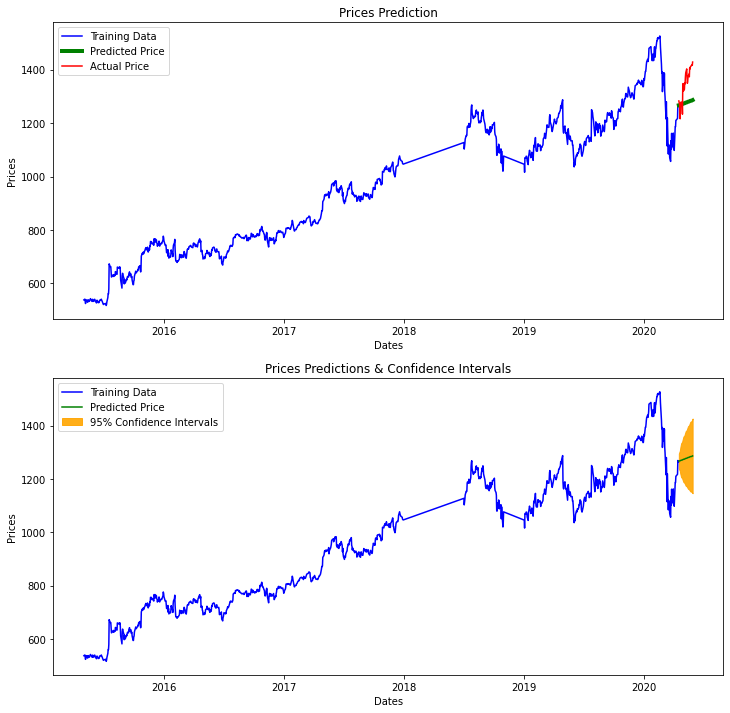

In [107]:
# Better forecast plots
plotForeCastBetter=symbolFolder+"/plot_ARIMA_forecast_better_"+symbol+".pdf"
fig, axes = pyplot.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(priceCloseTrain, color='blue', label='Training Data')
axes[0].plot(priceCloseTest.index, future_forecast, color='green', linewidth=4, label='Predicted Price')

axes[0].plot(priceCloseTest.index, priceCloseTest, color='red', label='Actual Price')
axes[0].set_title('Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(priceCloseTrain, color='blue', label='Training Data')
axes[1].plot(priceCloseTest.index, future_forecast, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(conf_int)
axes[1].fill_between(priceCloseTest.index, conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange', label="95% Confidence Intervals")
axes[1].legend()
pyplot.savefig(plotForeCastBetter, bbox_inches='tight')


mu=1286.397
SE=71.397


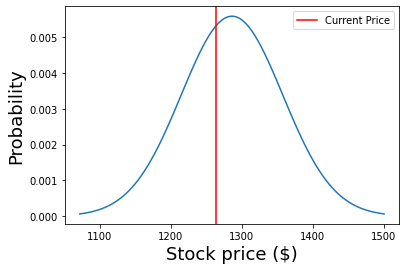

In [108]:
###### PROBABILITY GRAPH FROM ARIMA MODEL

# Note to Rim and Quinn: ARIMA model computes a predicted mean mu at kdays and a 95% confidence interval
# To compute the probability graph (AKA density function in statistics),
# we calculate the Standard Error (SE) from the lower bound of the confidence interval.
# Once we have the mean mu and the SE, then we can plot the probability graph.

# Current price
priceCloseCurrent=priceCloseTrain.iloc[len(priceCloseTrain)-1]

# Extract predicted mean and confidence interval
mu=future_forecast.iloc[kdays-1,0]
lower=conf_int[kdays-1,0]
print("mu="+str(round(mu,3)))

# Compute Standard Error (SE) from predicted confidence interval (reverse engineering here ;) )
se=(mu-lower)/norm.ppf(0.975)
print("SE="+str(round(se,3)))

# Probability graph
plotProbabilityGraph=symbolFolder+"/plot_ARIMA_probabilityGraph_"+symbol+"_"+str(kdays)+"days.pdf"
x = np.linspace(mu - 3*se, mu + 3*se, 100)
pyplot.plot(x, norm.pdf(x, mu, se))
pyplot.axvline(x=priceCloseCurrent,color='red',label='Current Price')
pyplot.xlabel('Stock price ($)', fontsize=18)
pyplot.ylabel('Probability', fontsize=18)
pyplot.legend(loc='upper right')
pyplot.savefig(plotProbabilityGraph, bbox_inches='tight')
pyplot.show()